In [1]:
from __future__ import division
import sys 
sys.path.insert(0,'../rl_network'); import actorcritic as ac
sys.path.insert(0,'../environments/'); import gridworld as eu
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline 
fig_savedir = '../data/figures/'
print_freq = 1/10

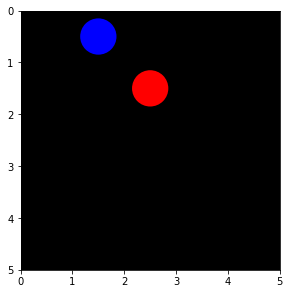

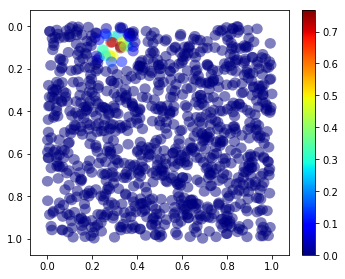

In [2]:
y_height = 5
x_width = 5

rho = 0
num_pc = 1000
fwhm = 0.05


#make environment
maze = eu.gridworld([y_height, x_width],
                    rho        = rho,
                    num_pc     = num_pc, 
                    pc_fwhm    = fwhm, 
                    maze_type  = 'none', 
                    port_shift = 'none')
#maze.rwd_loc = [(int(y_new/2),int(x_new/2))]
#print maze.fwhm
for i in maze.rwd_loc: 
    maze.orig_rwd_loc.append(i)

#show environment
eu.make_env_plots(maze,1,1,save=False)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

In [7]:
input_dims = num_pc 
action_dims = len(maze.actionlist)
batch_size = 1
hid_types = ['lstm', 'linear']
hid_dims = [500, 400]

NUM_EVENTS = 300
NUM_TRIALS = 1000


In [8]:
reload(ac)
MF = ac.AC_Net(input_dims, action_dims, batch_size, hid_types, hid_dims)
discount_factor = 0.98

eta = 5e-4 #gradient descent learning rate
opt = ac.optim.Adam(MF.parameters(), lr = eta)

In [9]:
total_loss = [[],[]]
total_reward = []

blocktime = time.time()
for trial in xrange(NUM_TRIALS):
    reward_sum = 0
    state = ac.Variable(ac.torch.FloatTensor(env.reset()))
    MF.reinit_hid()
    for event in xrange(NUM_EVENTS):
        policy_, value_ = MF(state)
        choice, policy, value = ac.select_action_end(MF,policy_, value_)
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)

        MF.rewards.append(reward)
        state = ac.Variable(ac.torch.FloatTensor(next_state))       # update state
        reward_sum += reward

    p_loss, v_loss = ac.finish_trial(MF, discount_factor,opt)
    
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)
    
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 

[16:23:54]  Trial 0 total reward = 9 (Avg 0.030) Block took 2.762
[16:28:48]  Trial 100 total reward = 295 (Avg 0.983) Block took 293.851


KeyboardInterrupt: 

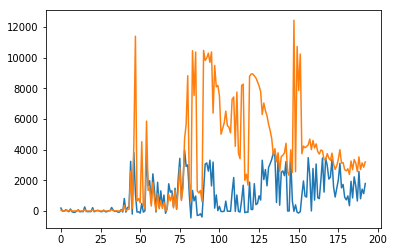

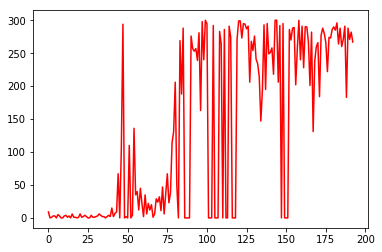

In [10]:
plt.plot(total_loss[0], label='p')
plt.plot(total_loss[1], label='v')
plt.show()

plt.plot(total_reward, label='r', color='r')